In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

In [ ]:
import plot_utils

In [2]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.models.wrapper.core.ActivationsExtractorHelper._from_sentences_stored"

In [3]:
model_identifier="gpt2-xl"
emb_context="Passage"
split_coord="Sentence"
testonperturbed=True
randomnouns=False

CAT2COND, COND2CAT = plot_utils.get_conditions(testonperturbed=testonperturbed, randomnouns=randomnouns)

In [4]:
def get_all_layers(model_identifier,categories_dict,scr_perturb=None):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        if "identifier=" + model_identifier in filename:
            if any(substring in filename for substring in categories_dict[scr_perturb]):
                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    result = pickle.load(f)
                result = result['data']
                layer_list = np.unique(result.layer)
                #order double-digit layers at end of list
                double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
                layers = [e for e in layer_list if e not in double_digits] + double_digits
                return layers
                break

In [5]:
def get_passage_identifier(filename):
    """
    get passage identifier to be used as key for the dictionary.
    important step: fill the identifier with 0s for single-digit passage numbers
    """
    passage = filename.split("-")[-1].split(".")[0]
    number = passage.split("sentences")[-1]
    if len(number) == 1:
        passage_identifier = passage[:-1] + number.zfill(2)
    else:
        passage_identifier = passage
    return passage_identifier

In [6]:
def get_dictionary(model_identifier,categories_dict,scr_perturb=None,layer_identifier=None, emb_context=None):
    """
    input: model identifier
    output: populated model dictionary with data of just the selected layer
    dictionary structure: passage_identifier --> condition identifier --> data
    """
    
    model_dictionary = model_identifier + "_dict"
    model_dictionary = {}
    
    #look at last layer by default
    if layer_identifier == None:
        layer_identifier = get_last_layer(model_identifier,categories_dict,scr_perturb=scr_perturb)
    else:
        layer_identifier = layer_identifier
    print("This is the layer I'm looking at: ", layer_identifier)
    print(f"This is the emb_context={emb_context}")
    
    for filename in tqdm(os.listdir(working_dir)):
        if not f"emb_context={emb_context}" in filename:
            continue
        if not f"identifier={model_identifier}" in filename:
            continue
            
        if (any(substring in filename for substring in categories_dict[scr_perturb])) or ("Original" in filename):
            passage_identifier = get_passage_identifier(filename)

            condition = filename.split("Pereira2018")[1]
            if "avgtoken" in model_identifier:
                condition = condition.split("avgtoken")[0]
            else:
                condition = condition.split("lasttoken")[0]
            condition = condition.lstrip("-").rstrip("-")

            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                out = pickle.load(f)
            result = out['data']
            data = result[{"neuroid": [layer == layer_identifier for layer in result["layer"].values]}]

            if not passage_identifier in model_dictionary:
                model_dictionary[passage_identifier] = {}
            model_dictionary[passage_identifier][condition] = data
    
    return model_dictionary

In [7]:
def get_arrays(dictionary,categories_dict,scr_perturb=None):
    #sort dictionary by passage identifier
    sorted_dict = dict(sorted(dictionary.items()))
    #create empty arrays
    
    if scr_perturb == "scrambled":
        original, scrambled1, scrambled3, scrambled5, scrambled7, lowpmi, lowpmi_random, backward, random_wl = ([] for i in range(len(categories_dict[scr_perturb])))
        for key, value in sorted_dict.items(): #key is passage, value is dic from cond to xarray data
            #print(list(value.keys()))
            original.append(value['Original'].values)
            scrambled1.append(value['Scr1'].values)
            scrambled3.append(value['Scr3'].values)
            scrambled5.append(value['Scr5'].values)
            scrambled7.append(value['Scr7'].values)
            lowpmi.append(value['lowPMI'].values)
            lowpmi_random.append(value['lowPMI-random'].values)
            backward.append(value['backward'].values)
            random_wl.append(value['random-wl'].values)
        
        return original,scrambled1,scrambled3,scrambled5,scrambled7,lowpmi,lowpmi_random,backward,random_wl
            
    elif scr_perturb == "perturb":
        original,nouns,nounsverbs,nounsverbsadj,contentwords,functionwords,sent_passage,sent_topic,sent_random = ([] for i in range(len(categories_dict[scr_perturb])))
        #
        for key, value in sorted_dict.items(): #key is passage, value is dic from cond to xarray data
            #print(list(value.keys()))
            original.append(value['Original'].values)
            nouns.append(value['nouns'].values)
            nounsverbs.append(value['nounsverbs'].values)
            nounsverbsadj.append(value['nounsverbsadj'].values)
            contentwords.append(value['contentwords'].values)
            #random_nouns.append(value['random-nouns'].values)
            functionwords.append(value['functionwords'].values)
            sent_passage.append(value['sentenceshuffle_passage'].values)
            sent_topic.append(value['sentenceshuffle_topic'].values)
            sent_random.append(value['sentenceshuffle_random'].values)
            
        
        print(np.shape(original))
        print(np.shape(original[0]))
        return original,nouns,nounsverbs,nounsverbsadj,contentwords,functionwords,sent_passage,sent_topic,sent_random

In [8]:
def flatten_array(liste):
    liste_flatten = [item for sublist in liste for item in sublist]
    return liste_flatten

In [9]:
def prepare_dataframe_perturb(original,nouns,nounsverbs,nounsverbsadj,contentwords,functionwords,sent_passage,sent_topic,sent_random,flatten=True):
    
    if flatten:
        df = pd.DataFrame(data={'original':np.asarray(flatten_array(original)).flatten(),
                               'nouns':np.asarray(flatten_array(nouns)).flatten(),
                               'nounsverbs':np.asarray(flatten_array(nounsverbs)).flatten(),
                               'nounsverbsadj':np.asarray(flatten_array(nounsverbsadj)).flatten(),
                               'contentwords':np.asarray(flatten_array(contentwords)).flatten(),
                               #'random-nouns' :np.asarray(flatten_array(random_nouns)).flatten(),
                               'functionwords':np.asarray(flatten_array(functionwords)).flatten(),
                               'sent_passage': np.asarray(flatten_array(sent_passage)).flatten(),
                               'sent_topic': np.asarray(flatten_array(sent_topic)).flatten(),
                               'sent_random' : np.asarray(flatten_array(sent_random)).flatten()
                               })
    if not flatten:
        df = {}
        df = {'original':flatten_array(original),
             'nouns':flatten_array(nouns),
              'nounsverbs':flatten_array(nounsverbs),
              'nounsverbsadj':flatten_array(nounsverbsadj),
              'contentwords':flatten_array(contentwords),
              #'random-nouns' : flatten_array(random_nouns),
              'functionwords':flatten_array(functionwords),
              'sent_passage':flatten_array(sent_passage),
              'sent_topic': flatten_array(sent_topic),
              'sent_random': flatten_array(sent_random)}
    return df

In [10]:
def prepare_dataframe_scrambled(original,scrambled1,scrambled3,scrambled5,scrambled7,lowpmi,lowpmi_random,backward,random_wl,flatten=True):
    
    if flatten:
        df = pd.DataFrame(data={'original':np.asarray(flatten_array(original)).flatten(),
                               'scrambled1':np.asarray(flatten_array(scrambled1)).flatten(),
                              'scrambled3' :np.asarray(flatten_array(scrambled3)).flatten(),
                              'scrambled5' :np.asarray(flatten_array(scrambled5)).flatten(),
                              'scrambled7':np.asarray(flatten_array(scrambled7)).flatten(),
                              'lowpmi':np.asarray(flatten_array(lowpmi)).flatten(),
                              'lowpmi_random':np.asarray(flatten_array(lowpmi_random)).flatten(),
                              'backward':np.asarray(flatten_array(backward)).flatten(),
                              'random-wl':np.asarray(flatten_array(random_wl)).flatten()
                               })
    if not flatten:
        # print(np.shape(np.asarray(flatten_array(random))))
        df = {}
        df = {'original':flatten_array(original),
             'scrambled1':flatten_array(scrambled1),
              'scrambled3' : flatten_array(scrambled3),
              'scrambled5' : flatten_array(scrambled5),
              'scrambled7':flatten_array(scrambled7),
              'lowpmi':flatten_array(lowpmi),
              'lowpmi_random':flatten_array(lowpmi_random),
              'backward':flatten_array(backward),
              'random-wl':flatten_array(random_wl)
             }
    return df

In [11]:
def main_df_for_plotting(model_identifier, scr_perturb=None, layer_identifier=None, emb_context=None, flatten=True):
    model_dict = get_dictionary(model_identifier, categories_dict, scr_perturb=scr_perturb, layer_identifier=layer_identifier,
                               emb_context=emb_context)
    if scr_perturb == "perturb":
        df = prepare_dataframe_perturb(*get_arrays(model_dict,categories_dict,scr_perturb=scr_perturb), flatten=flatten) #*flattens the tuple
    elif scr_perturb == "scrambled":
        df = prepare_dataframe_scrambled(*get_arrays(model_dict,categories_dict,scr_perturb=scr_perturb), flatten=flatten) #*flattens the tuple
    return df

In [12]:
def get_activation_dfs_for_all_layers(model_identifier, categories_dict, scr_perturb=None, emb_context=None, flatten=True):
    """
    input: model_identifier, whether to flatten (i.e. all sentence reps in one vector or leave 627*hidden size)
    output: dictionary: layer --> dataframe (conditions as column names, column values are flattened or unflattened activations)
    """
    print(f"This is the emb_context: {emb_context}!")
    layers = get_all_layers(model_identifier,categories_dict,scr_perturb=scr_perturb)
    print(f"Available layers: {layers}")
    layers = [layers[-1]]
    df_dict = {}
    for ind,elm in enumerate(layers):
        df_dict[elm] = main_df_for_plotting(model_identifier,scr_perturb=scr_perturb,layer_identifier=elm,
                                            emb_context=emb_context, flatten=flatten)
    return df_dict

In [13]:
from scipy import stats
def get_correlations_df_dict(model_identifier, categories_dict, scr_perturb=None, emb_context=None): #maybe pass activations dict as input so it doesn't have to recompute
    layers = get_all_layers(model_identifier, categories_dict, scr_perturb=scr_perturb)
    activations_dict = get_activation_dfs_for_all_layers(model_identifier, categories_dict, scr_perturb=scr_perturb, emb_context=emb_context)
    
    layers = [layers[-1]]
    conditions = list(activations_dict[layers[0]].columns)
    
    correlations_df_dict = {}
    for layer in layers:
        orig_column = activations_dict[layer]['original']
        correlations = [stats.spearmanr(orig_column,activations_dict[layer][elm])[0] for elm in conditions]
        #correlations = [orig_column.corr(activations_dict[layer][elm]) for elm in conditions]
        correlations_df_dict[layer] = correlations
    
    return layers, conditions, correlations_df_dict

In [14]:
def plot_correlations_lineplot(model_identifier, layers, conditions, correlations_dict,scr_perturb=None,
                              emb_context=None):
    fig, ax = plt.subplots()
    line_colors = sns.color_palette("rocket") + sns.color_palette("GnBu_d") + sns.color_palette("PRGn", 10) + sns.color_palette("YlOrBr", 10)
    
    counter = 0
    for key,value in correlations_dict.items():
        ax.plot(conditions,value, '-o',color=line_colors[counter])
        counter += 1

    ax.set_title(f'{model_identifier} | Layer model activation correlation with model activations for original sentence across conditions')
    ax.legend(layers)
    ax.yaxis.set_label_text('Spearman rho')
    #ax.yaxis.set_label_text('Pearson p')
    ax.legend(layers, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim([0, 1])
    plt.xticks(rotation= 90)
    
    if not os.path.isdir("fig"):
        os.mkdir("fig")
    savename = f'fig/{date.today()}_model-activation-correlation_{model_identifier}_{scr_perturb}.png'
    #plt.savefig(savename, bbox_inches='tight', dpi=240)

In [19]:
emb_context="Passage"

This is the emb_context: Passage!
Available layers: ['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5', 'encoder.h.6', 'encoder.h.7', 'encoder.h.8', 'encoder.h.9', 'encoder.h.10', 'encoder.h.11', 'encoder.h.12', 'encoder.h.13', 'encoder.h.14', 'encoder.h.15', 'encoder.h.16', 'encoder.h.17', 'encoder.h.18', 'encoder.h.19', 'encoder.h.20', 'encoder.h.21', 'encoder.h.22', 'encoder.h.23', 'encoder.h.24', 'encoder.h.25', 'encoder.h.26', 'encoder.h.27', 'encoder.h.28', 'encoder.h.29', 'encoder.h.30', 'encoder.h.31', 'encoder.h.32', 'encoder.h.33', 'encoder.h.34', 'encoder.h.35', 'encoder.h.36', 'encoder.h.37', 'encoder.h.38', 'encoder.h.39', 'encoder.h.40', 'encoder.h.41', 'encoder.h.42', 'encoder.h.43', 'encoder.h.44', 'encoder.h.45', 'encoder.h.46', 'encoder.h.47']
This is the layer I'm looking at:  encoder.h.47
This is the emb_context=Passage


  0%|          | 0/62612 [00:00<?, ?it/s]

/om2/user/ckauf/anaconda39/envs/perturbed3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(168,)
(4, 1600)


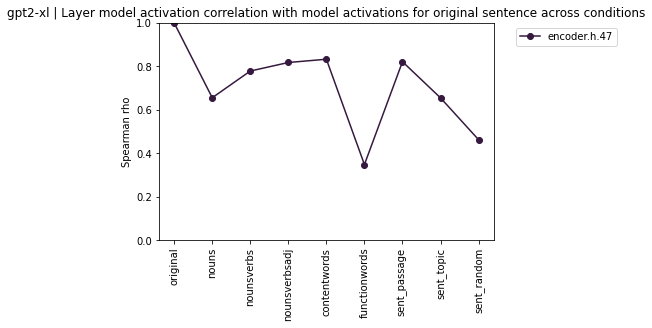

In [20]:
layers, conditions, corr_dict = get_correlations_df_dict("gpt2-xl",categories_dict, scr_perturb="perturb", emb_context=emb_context)
plot_correlations_lineplot("gpt2-xl", layers, conditions, corr_dict, scr_perturb="perturb", emb_context=emb_context)

This is the emb_context: Passage!
Available layers: ['drop', 'encoder.h.0', 'encoder.h.1', 'encoder.h.2', 'encoder.h.3', 'encoder.h.4', 'encoder.h.5', 'encoder.h.6', 'encoder.h.7', 'encoder.h.8', 'encoder.h.9', 'encoder.h.10', 'encoder.h.11', 'encoder.h.12', 'encoder.h.13', 'encoder.h.14', 'encoder.h.15', 'encoder.h.16', 'encoder.h.17', 'encoder.h.18', 'encoder.h.19', 'encoder.h.20', 'encoder.h.21', 'encoder.h.22', 'encoder.h.23', 'encoder.h.24', 'encoder.h.25', 'encoder.h.26', 'encoder.h.27', 'encoder.h.28', 'encoder.h.29', 'encoder.h.30', 'encoder.h.31', 'encoder.h.32', 'encoder.h.33', 'encoder.h.34', 'encoder.h.35', 'encoder.h.36', 'encoder.h.37', 'encoder.h.38', 'encoder.h.39', 'encoder.h.40', 'encoder.h.41', 'encoder.h.42', 'encoder.h.43', 'encoder.h.44', 'encoder.h.45', 'encoder.h.46', 'encoder.h.47']
This is the layer I'm looking at:  encoder.h.47
This is the emb_context=Passage


  0%|          | 0/62612 [00:00<?, ?it/s]

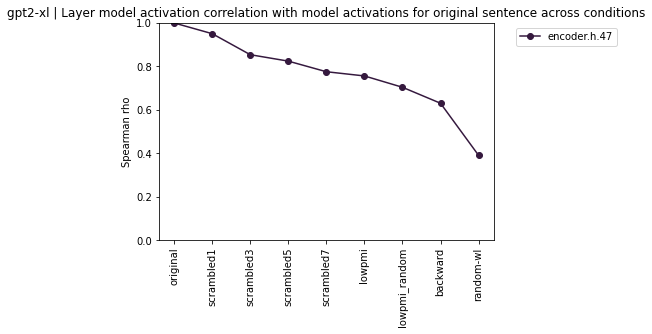

In [21]:
layers, conditions, corr_dict = get_correlations_df_dict("gpt2-xl",categories_dict, scr_perturb="scrambled", emb_context=emb_context)
plot_correlations_lineplot("gpt2-xl", layers, conditions, corr_dict, scr_perturb="scrambled", emb_context=emb_context)

In [18]:
# layers, conditions, corr_dict = get_correlations_df_dict("gpt2-xl",categories_dict, scr_perturb="perturb", emb_context="Passage")
# plot_correlations_lineplot("gpt2-xl", layers, conditions, corr_dict, scr_perturb="perturb")